In [ ]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
#from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [ ]:
#Get the Dataset
df=pd.read_csv("USstocks19_to_23.csv")
#Check the head of the dataset
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Classify
0,2019-01-02,187.820007,190.990005,186.699997,190.949997,160.983109,2475200.0,MMM,buy
1,2019-01-03,188.279999,188.279999,182.889999,183.759995,154.921448,3358200.0,MMM,sell
2,2019-01-04,186.750000,191.979996,186.029999,191.320007,161.295044,2995100.0,MMM,buy
3,2019-01-07,191.360001,192.300003,188.660004,190.880005,160.924057,2162200.0,MMM,sell
4,2019-01-08,193.000000,194.110001,189.580002,191.679993,161.598526,2479800.0,MMM,buy


In [ ]:
#Check dataset information e.g number of rows,columns, size etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552391 entries, 0 to 552390
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       552391 non-null  object 
 1   Open       552391 non-null  float64
 2   High       552391 non-null  float64
 3   Low        552391 non-null  float64
 4   Close      552391 non-null  float64
 5   Adj Close  552391 non-null  float64
 6   Volume     552391 non-null  float64
 7   Symbol     552391 non-null  object 
 8   Classify   552391 non-null  object 
dtypes: float64(6), object(3)
memory usage: 37.9+ MB


In [ ]:
#Check some basic statistics of the dataset
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,552391.000000,552391.000000,552391.000000,552391.000000,552391.000000,5.523910e+05
mean,150.398246,152.299717,148.461613,150.420955,146.633430,5.213184e+06
std,255.728349,259.124904,252.419441,255.831502,255.585910,1.315867e+07
min,3.220000,3.290000,3.020000,3.120000,2.996322,0.000000e+00
25%,52.270000,52.959999,51.570000,52.290001,49.439999,9.614000e+05
50%,94.489998,95.660004,93.260002,94.489998,90.690002,1.980200e+06
75%,173.279999,175.229996,171.190002,173.300484,168.018257,4.536550e+06
max,5979.359863,5986.959961,5908.000000,5967.220215,5967.220215,9.140820e+08


In [ ]:
#Check the last 3 rows of the dataset
df.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Classify
552388,2023-05-24,171.139999,171.389999,168.520004,169.139999,169.139999,2437900.0,ZTS,sell
552389,2023-05-25,169.630005,169.970001,163.570007,165.240005,165.240005,3626300.0,ZTS,sell
552390,2023-05-26,165.660004,166.630005,164.350006,164.740005,164.740005,1909400.0,ZTS,sell


<Axes: >

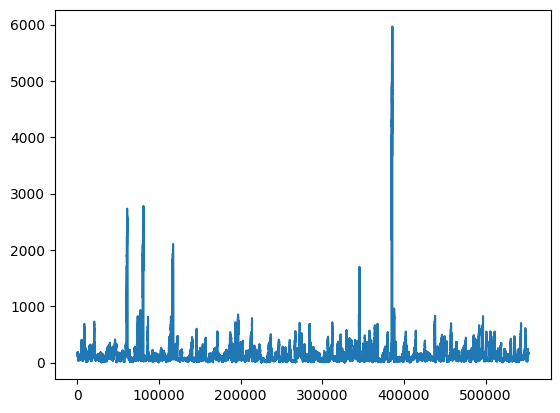

In [ ]:
#visualizer for Adj Close
df["Adj Close"].plot()

<Axes: >

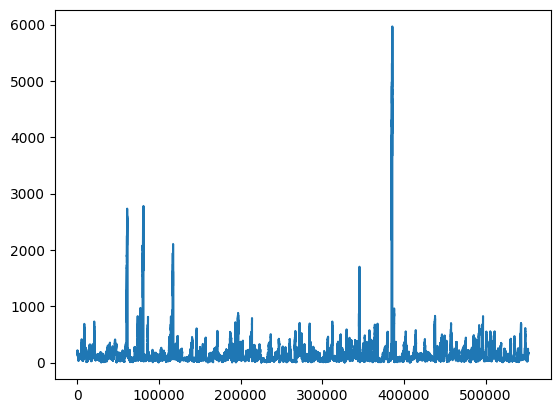

In [ ]:
#visualizer for Close
df["Close"].plot()

In [ ]:
#coverting buy and sell to 0s and 1s for the miodel
mapping = {"buy": 0, "sell": 1}

In [ ]:
#mapping the function 
df["Classify"]= df["Classify"].map(mapping)

In [ ]:
df["Classify"].value_counts()

0    287564
1    264827
Name: Classify, dtype: int64

In [ ]:
# Set the date column as the index.
df = df.set_index('Date')

In [ ]:
# Convert the index to pandas DateTimeIndex 
df.index = pd.to_datetime(df.index)

In [ ]:
# Split the data into features (X) and target variable (y)
X = df[['Close']]
y = df[['Classify']]

In [ ]:
# Determine the splitting point for the test set (last 6 months)
split_date = df.index[-1] - pd.DateOffset(months=6)

# Split the data into train and test sets
X_train = X[df.index < split_date]
y_train = y[df.index < split_date]
X_test = X[df.index >= split_date]
y_test = y[df.index >= split_date]

# Print the train and test set sizes
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 489779
Test set size: 62612


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Scale the data.
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)


# Reshape the input data for LSTM model
X_train = X_normalized.reshape((X_normalized.shape[0], X_normalized.shape[1], 1))
X_test = X_test_normalized.reshape((X_test_normalized.shape[0], X_test_normalized.shape[1], 1))

# Print the shapes of the train and test sets.
print(X_train.shape)
print(X_test.shape)

(489779, 1, 1)
(62612, 1, 1)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Create the model.
model = Sequential()
model.add(LSTM(128, input_shape=(1, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model.
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model.
model.fit(X_train, y_train, epochs=10)

# Evaluate the model.
loss = model.evaluate(X_test, y_test)
print('Test loss:', loss)

# Make predictions.
predictions = model.predict(X_test)

Epoch 1/10
15306/15306 [==============================] - 111s 7ms/step - loss: 0.2495
Epoch 2/10
15306/15306 [==============================] - 81s 5ms/step - loss: 0.2494
Epoch 3/10
15306/15306 [==============================] - 81s 5ms/step - loss: 0.2494
Epoch 4/10
15306/15306 [==============================] - 86s 6ms/step - loss: 0.2494
Epoch 5/10
15306/15306 [==============================] - 91s 6ms/step - loss: 0.2494
Epoch 6/10
15306/15306 [==============================] - 90s 6ms/step - loss: 0.2494
Epoch 7/10
15306/15306 [==============================] - 90s 6ms/step - loss: 0.2494
Epoch 8/10
15306/15306 [==============================] - 90s 6ms/step - loss: 0.2494
Epoch 9/10
15306/15306 [==============================] - 86s 6ms/step - loss: 0.2494
Epoch 10/10
1957/1957 [==============================] - 5s 2ms/step - loss: 0.2507
Test loss: 0.2507169842720032
1957/1957 [==============================] - 6s 3ms/step


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate the mean squared prediction error
mspe = mean_squared_error(y_test, predictions)

# Print the MSPE
print("MSPE:", mspe)

MSPE: 0.25071702776321436


In [ ]:
#Saving model to a file
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#Categorizing
threshold = 0.5
buy_sell_predictions = np.where(predictions > threshold, 'Buy', 'Sell')

In [ ]:
# Determine the splitting point for the test set (last 6 months)
split_date = df.index[-1] - pd.DateOffset(months=6)

# Split the data into train and test sets
X_train = X[df.index < split_date]
y_train = y[df.index < split_date]
X_test = X[df.index >= split_date]
y_test = y[df.index >= split_date]

In [ ]:
#predictions categorized into the top 5 buy and sell
symbols_test = df.loc[X_test.index, 'Symbol']
catego = pd.DataFrame()

In [ ]:
catego["Symbol"] = symbols_test

In [ ]:
catego["Actual values"] = y_test

In [ ]:
catego['Predictions'] = predictions

In [ ]:
top_5_buys = catego.groupby('Symbol').apply(lambda x: x.nlargest(5, 'Predictions'))
top_5_sells = catego.groupby('Symbol').apply(lambda x: x.nsmallest(5, 'Predictions'))

KeyboardInterrupt: ignored

In [ ]:
catego.to_csv("catego.csv")

In [ ]:
accuracy_rate = (predictions == y_test).mean()
print('Accuracy rate:', accuracy_rate)

In [ ]:
# Determine the splitting point for the test set (last 6 months)
split_date = df.index[-1] - pd.DateOffset(months=6)

# Split the data into train and test sets
X_train = X[df.index < split_date]
y_train = y[df.index < split_date]
X_test = X[df.index >= split_date]
y_test = y[df.index >= split_date]

# Print the train and test set sizes
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 489779
Test set size: 62612


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Fit the SARIMA model to the training data
model = SARIMAX(train_data['Classify'], order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit()

# Predict using the trained model on the test data
sarima_pred = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [ ]:
sarima_mspe = mean_squared_error(y_test, sarima_pred)

print(sarima_mspe)

0.2506495475080374


In [ ]:
final_results= pd.DataFrame()
models =["LSTM", "SARIMAX"]
joint_mspe = [mspe, sarima_mspe]
final_results["Model"] = models
final_results["MSPE"] = joint_mspe
final_results

,Model,MSPE
0,LSTM,0.250543
1,SARIMAX,0.250650


In [1]:
pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl
